In [1]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
import copy
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
from Bio.PDB import *
from Bio import pairwise2
from Bio.Seq import Seq
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import glob
import subprocess

import esm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


torch.set_grad_enabled(False)

In [ ]:
torch.cuda.set_device(1)

In [ ]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)


def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)


def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)


def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]


def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))
    
    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts


# Select sequences from the MSA to maximize the hamming distance
# Alternatively, can use hhfilter 
def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa
    
    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]


def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics


parser = PDBParser(PERMISSIVE = True, QUIET = True) 
pdbl = PDBList() 


def get_pdb_residues(PDB_ID):
    """ Returns a list of the indices of residues in the PDB file."""
    pdb = PDB_ID.upper()[:4]
    chain_id = PDB_ID.upper()[-1]
    
    ## Get the data from the pdb file
    pdbl.retrieve_pdb_file(PDB_ID.upper()[:4], pdir = '.', file_format = 'pdb')
    data = parser.get_structure(pdb,"pdb" + pdb.lower() + ".ent")
    os.remove("pdb" + pdb.lower() + ".ent")

    all_residues = {}
    
    missing = [res for res in data.header["missing_residues"] if res["chain"] == chain_id]
    for res in missing:
        key = res["ssseq"]
        all_residues[key] = False
    
    model = list(data.get_models())[0]
    chains = list(model.get_chains()) 
    residues = list([chain for chain in chains if chain.id == chain_id][0].get_residues())
    residues = [res for res in residues if str(res)[17] == ' ']
    for res in residues:
        if not str(res)[28].isnumeric():
            key = int(str(res)[26:28])
        elif not str(res)[29].isnumeric():
            key = int(str(res)[26:29])
        else:
            key = int(str(res)[26:30])
        all_residues[key] = True
    
    pdb_indices = []
    index = 0
    for i in range(10000):
        if i in all_residues:
            if all_residues[i]:
                pdb_indices.append(index)
            index += 1
    return pdb_indices


"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])


def display_output_heatmap(data, title):
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(24, 8))
    sns.heatmap(data, cmap='viridis', square=True, cbar=False, xticklabels=10, yticklabels=4)
    plt.title(title)
    plt.show()


def get_gpu_memory():
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv'], stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8')
    gpu_memory = [int(x.split()[0]) for x in output.strip().split('\n')[1:]]
    return gpu_memory


def get_subset_results(subsets, pdb_indices_0, pdb_indices_1, contacts, REF_0, REF_1, num_seqs=128):
    """ Returns MSA Transformer contact perdiction accuracy of subsets of an MSA."""
    msa_transformer_predictions = {}
    msa_transformer_results_0 = []
    msa_transformer_results_1 = []

    # pdb_indices_0 = get_pdb_residues(REF_0)
    # pdb_indices_1 = get_pdb_residues(REF_1)

    for name, inputs in enumerate(subsets + [read_msa(full_msa_path)]):
        torch.cuda.empty_cache()
        if len(inputs) > num_seqs:
            inputs = greedy_select(inputs, num_seqs=num_seqs)
        msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
        msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
        msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
        
        pdb_indices_0 = [i for i in pdb_indices_0 if i < len(msa_transformer_predictions[name])]
        prediction = msa_transformer_predictions[name][pdb_indices_0][:,pdb_indices_0]
        metrics = {"id": name, "reference":REF_0, "model": "MSA Transformer (Unsupervised)"}
        metrics.update(evaluate_prediction(prediction, contacts[REF_0][:len(pdb_indices_0),:len(pdb_indices_0)]))
        msa_transformer_results_0.append(metrics)

        pdb_indices_1 = [i for i in pdb_indices_1 if i < len(msa_transformer_predictions[name])]
        prediction = msa_transformer_predictions[name][pdb_indices_1][:,pdb_indices_1]
        metrics = {"id": name, "reference":REF_1, "model": "MSA Transformer (Unsupervised)"}
        metrics.update(evaluate_prediction(prediction, contacts[REF_1][:len(pdb_indices_1),:len(pdb_indices_1)]))
        msa_transformer_results_1.append(metrics)


    msa_transformer_results_0 = pd.DataFrame(msa_transformer_results_0)
    msa_transformer_results_1 = pd.DataFrame(msa_transformer_results_1)
    
    # Add a column for the number of sequences in the subset
    msa_transformer_results_0["num_seqs"] = [len(subsets[i]) for i in range(len(subsets))] + [num_seqs]
    msa_transformer_results_1["num_seqs"] = [len(subsets[i]) for i in range(len(subsets))] + [num_seqs]

    return msa_transformer_results_0, msa_transformer_results_1


def display_contact_results(results_0, results_1, title=None, color_by_seqs=True):
    """ Displays the contact prediction results compared with reference proteins in a 2D plot."""
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    if title is not None:
        fig.suptitle(title)

    # Loop over the subplots and plot the data
    for i, metric in enumerate(["long_P@L", "long_P@L2", "long_P@L5", "medium_P@L", "short_P@L", "local_P@L"]):
        row = i // 3
        col = i % 3
        axs[row, col].set_xlabel(f"{metric} for {REF_0}")
        axs[row, col].set_ylabel(f"{metric} for {REF_1}")
        axs[row, col].set_title(f"{metric} for {REF_0} and {REF_1}")
        
        axs[row, col].set_xlim([0, 1])
        axs[row, col].set_ylim([0, 1])

        # Adjusted num_seqs to give a roof of 128
        adjusted_num_seqs = results_0["num_seqs"].apply(lambda x: min(x, 128))

        if color_by_seqs:
            # Color the points by the number of sequences in the subset
            axs[row, col].scatter(results_0[metric][:-1], results_1[metric][:-1], s=10, c=adjusted_num_seqs[:-1], cmap='cool')
            axs[row, col].scatter(results_0[metric][-1:], results_1[metric][-1:], s=10, c='black', marker='s')
            # Add a color bar
            if col == 2:
                fig.colorbar(axs[row, col].collections[0], ax=axs[row, col])
        else:
            axs[row, col].scatter(results_0[metric][:-1], results_1[metric][:-1], s=10)
            axs[row, col].scatter(results_0[metric][-1:], results_1[metric][-1:], s=10, c='red')

    fig.tight_layout()
    plt.show()



In [ ]:
msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

In [ ]:
def get_pdb_indices(directory):
    fasta_path = glob.glob(directory + "fasta/*.seq")[0]
    reference_1_path = glob.glob(directory + "reference_1/*.pdb")[0]
    reference_2_path = glob.glob(directory + "reference_2/*.pdb")[0]

    # Read the fasta file
    with open(fasta_path, 'r') as file:
        fasta = file.read().split("\n")[1]

    pdb_sequences = []
    for reference_path in (reference_1_path, reference_2_path):
        # Get the amino acid sequence from the pdb file
        structure = parser.get_structure("Structure", reference_path)
        model = list(structure.get_models())[0]
        chains = list(model.get_chains())[0]
        residues = chains.get_residues()
        residues = [res.resname for res in residues if str(res)[17] == ' ']

        # Change the format of the amino acid sequence from 3-letter to 1-letter
        aa_dict = {'ALA':'A', 'ARG':'R', 'ASN':'N', 'ASP':'D', 'CYS':'C', 'GLU':'E', 'GLN':'Q', 'GLY':'G', 'HIS':'H', 'ILE':'I', 'LEU':'L', 'LYS':'K', 'MET':'M', 'PHE':'F', 'PRO':'P', 'SER':'S', 'THR':'T', 'TRP':'W', 'TYR':'Y', 'VAL':'V'}
        aa_sequence = "".join([aa_dict[res] for res in residues])
        pdb_sequences.append(aa_sequence)

    reference_1_sequence, reference_2_sequence = pdb_sequences
    
    alignment_12 = pairwise2.align.globalxx(Seq(reference_1_sequence), Seq(reference_2_sequence))

    a_12 = list(alignment_12[0].seqA)
    a_21 = list(alignment_12[0].seqB)

    l_12 = []
    l_21 = []
    index_1 = 0
    index_2 = 0
    for i in range(len(a_12)):
        if a_12[i] == a_21[i]:
            l_12.append(index_1)
            l_21.append(index_2)
        if a_12[i] != '-':
            index_1 += 1
        if a_21[i] != '-':
            index_2 += 1
    seq_12 = "".join([reference_1_sequence[i] for i in l_12])

    alignment_f1 = pairwise2.align.globalxx(Seq(fasta), Seq(seq_12))
    a_f = list(alignment_f1[0].seqA)
    a_1 = list(alignment_f1[0].seqB)

    l_1 = []
    l_2 = []
    l_f = []
    index_1 = 0
    index_2 = 0
    index_f = 0
    for i in range(len(a_1)):
        if a_f[i] == a_1[i]:
            l_1.append(l_12[index_1])
            l_2.append(l_21[index_2])
            l_f.append(index_f)
        if a_1[i] != '-':
            index_1 += 1
            index_2 += 1
        if a_f[i] != '-':
            index_f += 1

    return l_1, l_2, l_f



def get_results(input_directory, num_seqs=128):
    """ Returns MSA Transformer contact perdiction accuracy for a chosen protein."""

    reference_1 = glob.glob(input_directory + "reference_1/*")[0].split("/")[-1][:-4]
    reference_2 = glob.glob(input_directory + "reference_2/*")[0].split("/")[-1][:-4]

    pdb_file_1 = glob.glob(input_directory + "reference_1/*")[0]
    pdb_file_2 = glob.glob(input_directory + "reference_2/*")[0]

    structure_reference_1 = get_structure(PDBxFile.read(rcsb.fetch(reference_1[:4], "cif")))[0]
    structure_reference_2 = get_structure(PDBxFile.read(rcsb.fetch(reference_2[:4], "cif")))[0]

    contacts_reference_1 = contacts_from_pdb(structure_reference_1, chain=reference_1[-1].upper())
    contacts_reference_2 = contacts_from_pdb(structure_reference_2, chain=reference_2[-1].upper())

    #pdb_indices_1 = get_indices(pdb_file_1, reference_1[-1])
    #pdb_indices_2 = get_indices(pdb_file_2, reference_2[-1])
    pdb_indices_1, pdb_indices_2, fasta_indices = get_pdb_indices(input_directory)

    colab_msa_path = glob.glob(input_directory + "alignments/colab_*")[0]
    hhblits_msa_path = glob.glob(input_directory + "alignments/aligned_*")[0]
    
    
    msa_transformer_predictions = {}
    msa_transformer_results_1 = []
    msa_transformer_results_2 = []
    sequences = []

    clusters = glob.glob(input_directory + "af_clusters/*") + [colab_msa_path, hhblits_msa_path]
    for cluster_path in clusters:
        if cluster_path.find("_U1") != -1 or not cluster_path.endswith(".a3m"):
            continue
        name = cluster_path.split("/")[-1]
        inputs = read_msa(cluster_path)
        torch.cuda.empty_cache()
        sequences.append(len(inputs))
        if len(inputs) > num_seqs:
            inputs = greedy_select(inputs, num_seqs=num_seqs)
        msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
        msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
        msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
        
        #pdb_indices_1 = [i for i in pdb_indices_1 if i < len(msa_transformer_predictions[name])]
        prediction = msa_transformer_predictions[name][fasta_indices][:,fasta_indices]
        metrics = {"id": name, "reference":reference_1, "model": "MSA Transformer (Unsupervised)"}
        metrics.update(evaluate_prediction(prediction, contacts_reference_1[pdb_indices_1][:,pdb_indices_1]))
        msa_transformer_results_1.append(metrics)

        #pdb_indices_2 = [i for i in pdb_indices_2 if i < len(msa_transformer_predictions[name])]
        prediction = msa_transformer_predictions[name][fasta_indices][:,fasta_indices]
        metrics = {"id": name, "reference":reference_2, "model": "MSA Transformer (Unsupervised)"}
        metrics.update(evaluate_prediction(prediction, contacts_reference_2[pdb_indices_2][:,pdb_indices_2]))
        msa_transformer_results_2.append(metrics)
    
    msa_transformer_results_1 = pd.DataFrame(msa_transformer_results_1)
    msa_transformer_results_2 = pd.DataFrame(msa_transformer_results_2)

    msa_transformer_results_1["num_seqs"] = sequences
    msa_transformer_results_2["num_seqs"] = sequences

    return msa_transformer_results_1, msa_transformer_results_2


def display_contact_results(results_0, results_1, title=None, color_by_seqs=True):
    """ Displays the contact prediction results compared with reference proteins in a 2D plot."""

    reference_0 = results_0["reference"][0]
    reference_1 = results_1["reference"][0]

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    if title is not None:
        fig.suptitle(title)

    # Loop over the subplots and plot the data
    for i, metric in enumerate(["long_P@L", "long_P@L2", "long_P@L5", "medium_P@L", "short_P@L", "local_P@L"]):
        row = i // 3
        col = i % 3
        axs[row, col].set_xlabel(f"{metric} for {reference_0}")
        axs[row, col].set_ylabel(f"{metric} for {reference_1}")
        axs[row, col].set_title(f"{metric} for {reference_0} and {reference_1}")
        
        axs[row, col].set_xlim([0, 1])
        axs[row, col].set_ylim([0, 1])

        # Adjusted num_seqs to give a roof of 128
        adjusted_num_seqs = results_0["num_seqs"].apply(lambda x: min(x, 128))

        if color_by_seqs:
            # Color the points by the number of sequences in the subset
            axs[row, col].scatter(results_0[metric][:-1], results_1[metric][:-1], s=10, c=adjusted_num_seqs[:-1], cmap='cool')
            axs[row, col].scatter(results_0[metric][-1:], results_1[metric][-1:], s=10, c='black', marker='s')
            # Add a color bar
            if col == 2:
                fig.colorbar(axs[row, col].collections[0], ax=axs[row, col])
        else:
            axs[row, col].scatter(results_0[metric][:-1], results_1[metric][:-1], s=10)
            axs[row, col].scatter(results_0[metric][-2:-1], results_1[metric][-2:-1], s=10, c='orange')
            axs[row, col].scatter(results_0[metric][-1:], results_1[metric][-1:], s=10, c='red')

    fig.tight_layout()
    plt.show()



In [47]:
benchmark_protein_path = "/home/vera/projects/masters_project/data/benchmark_data/af_cluster_monomeric/RfaH/"
#benchmark_protein_path = "/home/vera/projects/masters_project/data/benchmark_data/af_cluster_monomeric/KaiB/"

In [48]:
results_1, results_2 = get_results(benchmark_protein_path, num_seqs=128)
display_contact_results(results_1, results_2, title=benchmark_protein_path.split("/")[-2], color_by_seqs=False)

tensor([[0.0044, 0.0229, 0.0201,  ..., 0.0026, 0.0024, 0.0051],
        [0.0229, 0.0048, 0.0102,  ..., 0.0038, 0.0024, 0.0037],
        [0.0201, 0.0102, 0.0072,  ..., 0.0027, 0.0023, 0.0028],
        ...,
        [0.0026, 0.0038, 0.0027,  ..., 0.0047, 0.0049, 0.0042],
        [0.0024, 0.0024, 0.0023,  ..., 0.0049, 0.0147, 0.0049],
        [0.0051, 0.0037, 0.0028,  ..., 0.0042, 0.0049, 0.0092]])


RuntimeError: value cannot be converted to type int64_t without overflow

: 

In [ ]:
def download_pdb_chain(pdb_id, path):
    """ Downloads a PDB file for a given PDB ID and chain ID."""
    pdb = pdb_id.upper()[:4]
    chain_id = pdb_id.upper()[-1]

    # Download the PDB file
    parser = PDBParser()
    pdbl.retrieve_pdb_file(pdb, pdir = path, file_format = 'pdb')
    structure = parser.get_structure(pdb, path + "pdb" + pdb.lower() + ".ent")
    os.remove(path + "pdb" + pdb.lower() + ".ent")

    model = copy.deepcopy(structure[0])
    for i, chain in reversed([c for c in enumerate(model.child_list)]):
        # Remove all chains except the one we want
        if chain.id != chain_id:
            model.child_list.remove(model.child_list[i])
        else:
            # Remove all hetatoms
            for i, residue in reversed([r for r in enumerate(chain.child_list)]):
                if residue.id[0] != ' ':
                    chain.child_list.remove(chain.child_list[i])

    # Create a new PDB file
    io=PDBIO()
    io.set_structure(model)
    io.save(path + pdb_id + ".pdb")

In [191]:
def get_pdb_indices(directory):
    fasta_path = glob.glob(directory + "fasta/*.seq")[0]
    reference_1_path = glob.glob(directory + "reference_1/*.pdb")[0]
    reference_2_path = glob.glob(directory + "reference_2/*.pdb")[0]

    # Read the fasta file
    with open(fasta_path, 'r') as file:
        fasta = file.read().split("\n")[1]

    pdb_sequences = []
    for reference_path in (reference_1_path, reference_2_path):
        # Get the amino acid sequence from the pdb file
        structure = parser.get_structure("Structure", reference_path)
        model = list(structure.get_models())[0]
        chains = list(model.get_chains())[0]
        residues = chains.get_residues()
        residues = [res.resname for res in residues if str(res)[17] == ' ']

        # Change the format of the amino acid sequence from 3-letter to 1-letter
        aa_dict = {'ALA':'A', 'ARG':'R', 'ASN':'N', 'ASP':'D', 'CYS':'C', 'GLU':'E', 'GLN':'Q', 'GLY':'G', 'HIS':'H', 'ILE':'I', 'LEU':'L', 'LYS':'K', 'MET':'M', 'PHE':'F', 'PRO':'P', 'SER':'S', 'THR':'T', 'TRP':'W', 'TYR':'Y', 'VAL':'V'}
        aa_sequence = "".join([aa_dict[res] for res in residues])
        pdb_sequences.append(aa_sequence)

    reference_1_sequence, reference_2_sequence = pdb_sequences
    
    alignment_12 = pairwise2.align.globalxx(Seq(reference_1_sequence), Seq(reference_2_sequence))

    a_12 = list(alignment_12[0].seqA)
    a_21 = list(alignment_12[0].seqB)

    l_12 = []
    l_21 = []
    index_1 = 0
    index_2 = 0
    for i in range(len(a_12)):
        if a_12[i] == a_21[i]:
            l_12.append(index_1)
            l_21.append(index_2)
        if a_12[i] != '-':
            index_1 += 1
        if a_21[i] != '-':
            index_2 += 1
    seq_12 = "".join([reference_1_sequence[i] for i in l_12])

    alignment_f1 = pairwise2.align.globalxx(Seq(fasta), Seq(seq_12))
    a_f = list(alignment_f1[0].seqA)
    a_1 = list(alignment_f1[0].seqB)

    l_1 = []
    l_2 = []
    l_f = []
    index_1 = 0
    index_2 = 0
    index_f = 0
    for i in range(len(a_1)):
        if a_f[i] == a_1[i]:
            l_1.append(l_12[index_1])
            l_2.append(l_21[index_2])
            l_f.append(index_f)
        if a_1[i] != '-':
            index_1 += 1
            index_2 += 1
        if a_f[i] != '-':
            index_f += 1

    return l_1, l_2, l_f


In [196]:
l1, l2, lf = get_pdb_indices(benchmark_protein_path)
print(l1)
print(l2)
print(lf)

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 90, 91, 92, 93, 94, 98, 99]
[4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 94, 95, 96, 97, 98, 101, 102]
[4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75

In [ ]:
PDB_ID = "1duj_a"
path = "/home/vera/projects/masters_project/data/benchmark_data/"

download_pdb_chain(PDB_ID, path)

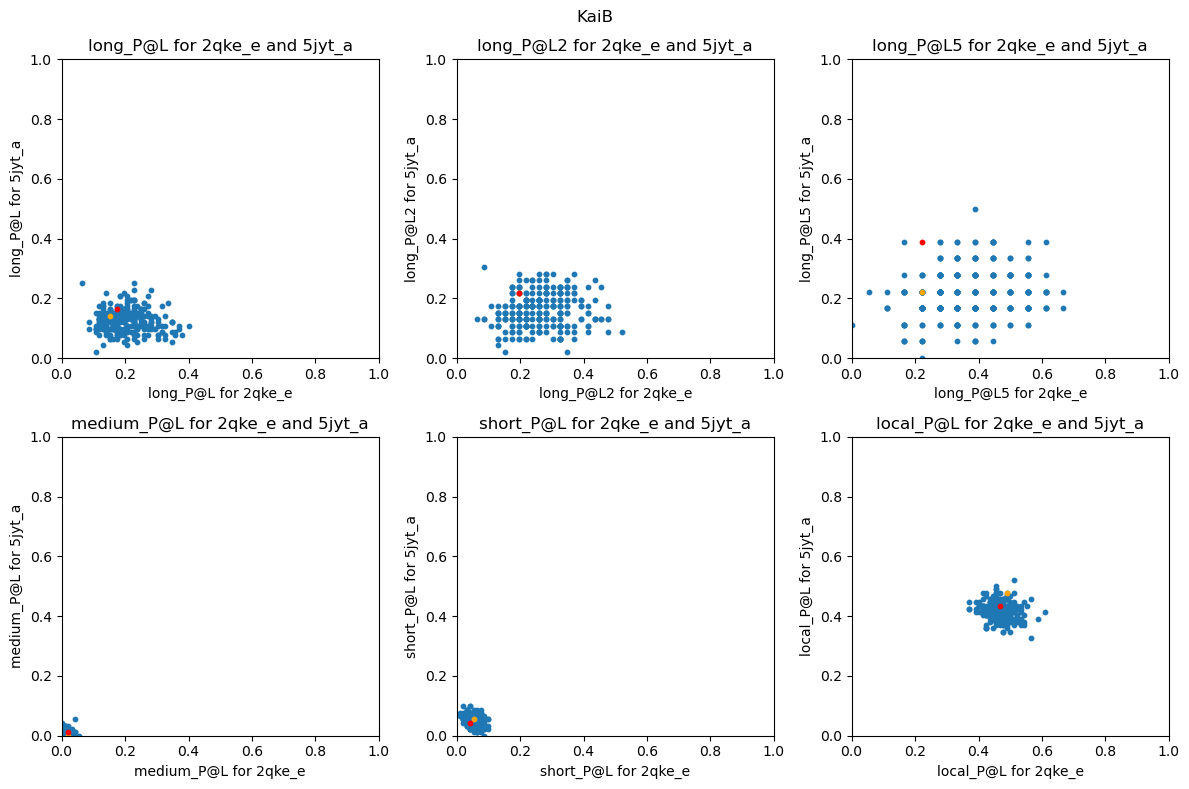

In [202]:
display_contact_results(results_1, results_2, title=benchmark_protein_path.split("/")[-2], color_by_seqs=False)

In [188]:
#protien_dir = "/home/vera/projects/masters_project/data/benchmark_data/af_cluster_monomeric/KaiB/"
protien_dir = "/home/vera/projects/masters_project/data/benchmark_data/af_cluster_monomeric/Mad2/"
protien_dir = "/home/vera/projects/masters_project/data/benchmark_data/af_cluster_monomeric/RfaH/"
protien_dir = "/home/vera/projects/masters_project/data/benchmark_data/af_cluster_oligomeric/Selecase/"
protien_dir = "/home/vera/projects/masters_project/data/benchmark_data/af_cluster_oligomeric/CLIC1/"
protien_dir = "/home/vera/projects/masters_project/data/benchmark_data/af_cluster_oligomeric/Lymphotactin/"

fasta_path = glob.glob(protien_dir + "fasta/*.seq")[0]
reference_1_path = glob.glob(protien_dir + "reference_1/*.pdb")[0]
reference_2_path = glob.glob(protien_dir + "reference_2/*.pdb")[0]

# Read the fasta file
with open(fasta_path, 'r') as file:
    fasta = file.read().split("\n")[1]

pdb_sequences = []
for reference_path in (reference_1_path, reference_2_path):
    # Get the amino acid sequence from the pdb file
    structure = parser.get_structure("Structure", reference_path)
    model = list(structure.get_models())[0]
    chains = list(model.get_chains())[0]
    residues = chains.get_residues()
    residues = [res.resname for res in residues if str(res)[17] == ' ']

    # Change the format of the amino acid sequence from 3-letter to 1-letter
    aa_dict = {'ALA':'A', 'ARG':'R', 'ASN':'N', 'ASP':'D', 'CYS':'C', 'GLU':'E', 'GLN':'Q', 'GLY':'G', 'HIS':'H', 'ILE':'I', 'LEU':'L', 'LYS':'K', 'MET':'M', 'PHE':'F', 'PRO':'P', 'SER':'S', 'THR':'T', 'TRP':'W', 'TYR':'Y', 'VAL':'V'}
    aa_sequence = "".join([aa_dict[res] for res in residues])
    pdb_sequences.append(aa_sequence)

reference_1_sequence, reference_2_sequence = pdb_sequences

alignment_1 = pairwise2.align.globalxx(Seq(fasta), Seq(reference_1_sequence))
print(pairwise2.format_alignment(*alignment_1[0]))

alignment_2 = pairwise2.align.globalxx(Seq(fasta), Seq(reference_2_sequence))
print(pairwise2.format_alignment(*alignment_2[0]))

alignment_12 = pairwise2.align.globalxx(Seq(reference_1_sequence), Seq(reference_2_sequence))
print(pairwise2.format_alignment(*alignment_12[0]))



VGSEVSDKRTCVSLTTQRLPVSRIKTYTITEGSLRAVIFITKRGLKVCADPQATWVRDVVRSMDRKSNTRNNMIQTKPTGTQQSTNTAVTLTG
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
VGSEVSDKRTCVSLTTQRLPVSRIKTYTITEGSLRAVIFITKRGLKVCADPQATWVRDVVRSMDRKSNTRNNMIQTKPTGTQQSTNTAVTLTG
  Score=93

VGSEVSDKRTCVSLTTQRLPVSRIKTYTITEGSLRAVIFITKRGLKVCADPQATWVRDVVRSMDRKSNTRNNMIQTKPTGTQQSTNTAVTLTG
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||| |                            |    
VGSEVSDKRTCVSLTTQRLPVSRIKTYTITEGSLRAVIFITKRGLKVCADPQATWVRD-V----------------------------V----
  Score=60

VGSEVSDKRTCVSLTTQRLPVSRIKTYTITEGSLRAVIFITKRGLKVCADPQATWVRDVVRSMDRKSNTRNNMIQTKPTGTQQSTNTAVTLTG
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||| |                            |    
VGSEVSDKRTCVSLTTQRLPVSRIKTYTITEGSLRAVIFITKRGLKVCADPQATWVRD-V----------------------------V----
  Score=60



In [189]:

a_12 = list(alignment_12[0].seqA)
a_21 = list(alignment_12[0].seqB)

l_12 = []
l_21 = []
index_1 = 0
index_2 = 0
for i in range(len(a_12)):
    if a_12[i] == a_21[i]:
        l_12.append(index_1)
        l_21.append(index_2)
    if a_12[i] != '-':
        index_1 += 1
    if a_21[i] != '-':
        index_2 += 1
seq_12 = "".join([reference_1_sequence[i] for i in l_12])

alignment_f1 = pairwise2.align.globalxx(Seq(fasta), Seq(seq_12))
print(pairwise2.format_alignment(*alignment_f1[0]))
a_f = list(alignment_2[0].seqA)
a_1 = list(alignment_2[0].seqB)

l_1 = []
l_2 = []
l_f = []
index_1 = 0
index_2 = 0
index_f = 0
for i in range(len(a_1)):
    if a_f[i] == a_1[i]:
        l_1.append(l_12[index_1])
        l_2.append(l_21[index_2])
        l_f.append(index_f)
    if a_1[i] != '-':
        index_1 += 1
        index_2 += 1
    if a_f[i] != '-':
        index_f += 1
    
seq = "".join([reference_1_sequence[i] for i in l_1])

print(l_12)
print(len(l_12))
print(l_21)
print(len(l_21))

print(l_1)
print(len(l_1))
print(l_2)
print(len(l_2))
print(l_f)
print(len(l_f))

VGSEVSDKRTCVSLTTQRLPVSRIKTYTITEGSLRAVIFITKRGLKVCADPQATWVRDVVRSMDRKSNTRNNMIQTKPTGTQQSTNTAVTLTG
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||| |                            |    
VGSEVSDKRTCVSLTTQRLPVSRIKTYTITEGSLRAVIFITKRGLKVCADPQATWVRD-V----------------------------V----
  Score=60

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 88]
60
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
60
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 88]
60
[0, 

In [177]:
seq_12

'KDRKILNEILSNTINELNLNDKKANIKIKIKPLKRKIASISLTNKTIYINKNILPYLSDEEIRFILAHELLHLKYGKYHINEFEEELLFLFPNKEAILINLINKLHQK'